In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import finesse
from scipy.optimize import minimize
from finesse.gaussian import BeamParam
import matplotlib.colors as colors
import scipy
from scipy.optimize import curve_fit
from sympy import *
import sympy as sp
from sympy import init_printing
init_printing() 

finesse.configure(plotting=True)
import warnings
warnings.filterwarnings('ignore')

### Beam-expanding telescopes **INSIDE** CE arms:

In [4]:
variables = """
# ------------------------------------------------------------------------------
# variables
# ------------------------------------------------------------------------------
variable nsilica 1.44963098985906
variable Mloss 30u

variable L_ARM 40k
variable TM_Rc 25.2049k

variable PRMRc 50
variable SEMRc -50
variable l_PRM_BS 50
variable l_BS_SEM 50

variable l_BS_XM2 50
variable XM2Rc -50
variable l_XM2_XM3 50
variable XM3Rc 50

variable l_XM3_ITMXlens 50

variable ITMX_lensf 10k
"""

In [5]:
base = finesse.Model()
base.parse(variables)
base.parse("""
l l1 P=165
s ll1_PRM l1.p1 PRMAR.p1

# ------------------------------------------------------------------------------
# Power recycling cavity
# ------------------------------------------------------------------------------
m PRMAR R=0 T=0.99996 # compound mirrors PRM, ITMX, and SEM
s sPRMsub PRMAR.p2 PRM.p1 L=0.0737 nr=&nsilica
m PRM R=0.9699915 T=0.03 Rc=PRMRc
s lPRM_BS PRM.p2 BS.p1 L=l_PRM_BS

bs BS R=0.5 T=0.5
# ------------------------------------------------------------------------------
# Y-arm
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# X-arm
# ------------------------------------------------------------------------------
s lBS_XM2 BS.p3 XM2.p1 L=l_BS_XM2
bs XM2 T=250u L=37.5u alpha=-1 Rc=XM2Rc
s lXM2_XM3 XM2.p2 XM3.p1 L=l_XM2_XM3
bs XM3 T=0 L=37.5u alpha=1 Rc=XM3Rc
s lXM3_ITMXlens XM3.p2 ITMX_lens.p1 L=l_XM3_ITMXlens

lens ITMX_lens ITMX_lensf

s lITMX ITMX_lens.p2 ITMXAR.p1

m ITMXAR T=0.99998 L=20u
s sITMXsub1 ITMXAR.p2 ITMX.p1 L=0.4 nr=nsilica
m ITMX T=0.014 L=Mloss phi=0 Rc=-TM_Rc

s LY ITMX.p2 ETMX.p1 L=L_ARM
m ETMX T=5u L=Mloss phi=0 Rc=TM_Rc

cav cavXARM source=ITMX.p2.o via=ETMX.p1.i priority=2
#cav cavPRX PRM.p2.o via=ITMX.p1.i priority=1
# ------------------------------------------------------------------------------
# Sginal recycling cavity
# ------------------------------------------------------------------------------
s lBS_SEM BS.p4 SEM.p1 L=l_BS_SEM
m SEM R=0.7999913 T=0.2 L=8.7u Rc=SEMRc
s SEMsub SEM.p2 SEMAR.p1 L=0.0749 nr=nsilica
m SEMAR R=0 T=0.99999995 L=50n
# ------------------------------------------------------------------------------
# Output optics
# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# Power detectors
# ------------------------------------------------------------------------------
"""
)

In [6]:
kat = base.deepcopy()

l_XM3_ITMXlens = 100
l_XM2_XM3 = 45.5
l_BS_XM2 = 50
l_BS_SEM = 30

XM2Rc = -9.6
XM3Rc = 100
ITMX_lensf = np.inf

SEMRc = -79.59188
PRMRc = 50
l_PRM_BS = 50

kat.PRMRc.value = PRMRc
kat.SEMRc.value = SEMRc
kat.l_PRM_BS.value = l_PRM_BS
kat.l_BS_SEM.value = l_BS_SEM
kat.l_BS_XM2.value = l_BS_XM2
kat.XM2Rc.value = XM2Rc
kat.l_XM2_XM3.value = l_XM2_XM3
kat.XM3Rc.value = XM3Rc
kat.l_XM3_ITMXlens.value = l_XM3_ITMXlens
kat.ITMX_lensf.value = ITMX_lensf

katt = kat.deepcopy()

In [9]:
ITMX_TO_SEM = katt.path(katt.ITMX.p1, katt.SEM.p1)
SEC_ps_sym = katt.propagate_beam(path=ITMX_TO_SEM, symbolic=True)
Rc_SEM_sym = SEC_ps_sym.q(katt.SEM.p1.i).Rc
Rc_SEM_sym.eval()

# print(Rc_SEM_sym)
# Rc_SEM_sym.eval(subs={"XM3.alpha":1})

-79.59188167303239

In [23]:
Rc_SEM_sym

<Symbolic='(real((((((((15471.139776521943+5444.475430987707j)+sITMXsub1.L/sITMXsub1.nr)*(((lITMX.nr-sITMXsub1.nr)/-ITMXAR.Rcx*((15471.139776521943+5444.475430987707j)+sITMXsub1.L/sITMXsub1.nr)+1.0))**(-1)*1.0+lITMX.L/lITMX.nr)*((-1.0/ITMX_lens.f*(((15471.139776521943+5444.475430987707j)+sITMXsub1.L/sITMXsub1.nr)*(((lITMX.nr-sITMXsub1.nr)/-ITMXAR.Rcx*((15471.139776521943+5444.475430987707j)+sITMXsub1.L/sITMXsub1.nr)+1.0))**(-1)*1.0+lITMX.L/lITMX.nr)+1.0))**(-1)*1.0+lXM3_ITMXlens.L/lXM3_ITMXlens.nr)*(((-2*lXM3_ITMXlens.nr)/(XM3.Rcx*cos(radians(XM3.alpha)))*((((15471.139776521943+5444.475430987707j)+sITMXsub1.L/sITMXsub1.nr)*(((lITMX.nr-sITMXsub1.nr)/-ITMXAR.Rcx*((15471.139776521943+5444.475430987707j)+sITMXsub1.L/sITMXsub1.nr)+1.0))**(-1)*1.0+lITMX.L/lITMX.nr)*((-1.0/ITMX_lens.f*(((15471.139776521943+5444.475430987707j)+sITMXsub1.L/sITMXsub1.nr)*(((lITMX.nr-sITMXsub1.nr)/-ITMXAR.Rcx*((15471.139776521943+5444.475430987707j)+sITMXsub1.L/sITMXsub1.nr)+1.0))**(-1)*1.0+lITMX.L/lITMX.nr)+1.0)

In [24]:
L3_sym, L2_sym, L1_sym, R2_sym, R3_sym = symbols("L3_sym, L2_sym, L1_sym, R2_sym, R3_sym", real=True)

L3, L2, L1, R2, R3 = symbols("L3, L2, L1, R2, R3", real=True)

L3_num = 100
L2_num = 45.5
L1_num = 80

R2_num = -9.6
R3_num = 100
alpha_num = 1*np.pi/180

L3_sym = L3*L3_num
L2_sym = L2*L2_num
L1_sym = L1*L1_num

R2_sym = R2*R2_num
R3_sym = R3*R3_num

l_XM3_ITMXlens = 100
l_XM2_XM3 = 45.5
l_BS_XM2 = 50
l_BS_SEM = 30
XM2Rc = -9.6

subs={"lXM3_ITMXlens.L":l_XM3_ITMXlens, "lBS_XM2.L":l_BS_XM2, "lBS_SEM.L":l_BS_SEM, "XM2.Rc":XM2Rc,}

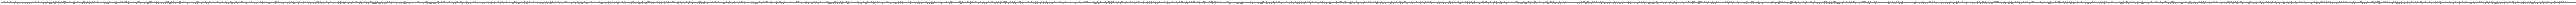

In [25]:
Rc_SEM_sympy = Rc_SEM_sym.eval(subs=subs, keep=["lXM2_XM3.L", "XM3.Rcx"]).to_sympy()
Rc_SEM_sympy = Rc_SEM_sympy.subs({"lXM2_XM3.L": L2_sym, "XM3.Rcx":R3_sym})
Rc_SEM_sympy_sim = cancel(simplify(Rc_SEM_sympy.evalf(n=25)))
factor(Rc_SEM_sympy_sim)

In [26]:
Rc_SEM_sympy_sim.subs({L2:1, R3:1})

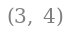

In [44]:
def get_indices(expr):
    a_count = 0
    b_count = 0
    for term in Mul.make_args(expr):
        if isinstance(term, Pow):
            base, exp = term.as_base_exp()
            if base == L2:
                a_count += exp
            elif base == R3:
                b_count += exp
    return a_count, b_count

get_indices(L2**3*R3**4)

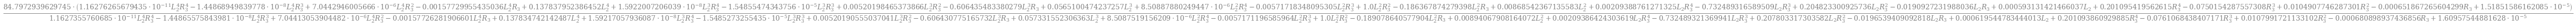

In [45]:
n_, d_ = fraction(Rc_SEM_sympy_sim)

nns = [nn for nn in n_.args if get_indices(nn)[0]<=4 and get_indices(nn)[1]<=4]
dds = [dd for dd in d_.args if get_indices(dd)[0]<=4 and get_indices(dd)[1]<=4]
    
n = Add(*nns)
d = Add(*dds)
Rc_SEM_sympy_sim = n/d
factor(Rc_SEM_sympy_sim)

In [46]:
Rc_SEM_sympy_sim.subs({L2:1, R3:1})

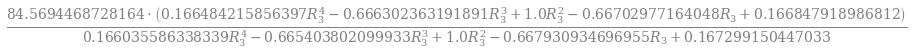

In [48]:
Rc_sym = cancel(simplify(Rc_SEM_sympy_sim.subs({L2:1})))
factor(Rc_sym)

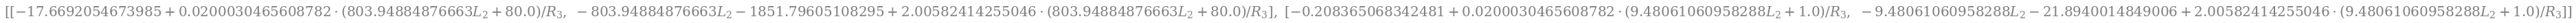

In [40]:
ABCD = finesse.tracing.tools.compute_abcd(path=ITMX_TO_SEM, symbolic=True)

ABCD_sym = [[element.eval(subs=subs, keep=["lXM2_XM3.L", "XM3.Rcx"]).to_sympy().subs({"lXM2_XM3.L": L2_sym, "XM3.Rcx":R3_sym}).evalf(n=15) \
             for element in row] for row in ABCD.M]

ABCD_sym

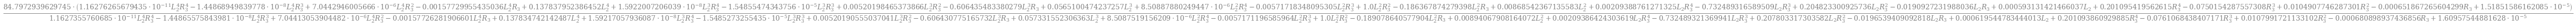

In [41]:
def Propagation_sym(ABCD, q):
    ABCD_res = ABCD*Matrix([q/1.44963098985906, 1])
    q_res = ABCD_res[0]/ABCD_res[1]
    return q_res

q_in = kat.beam_trace()[kat.ITMX.p1.o][0].q
q_out_sym = Propagation_sym(sp.Matrix(ABCD_sym), q_in)

z_out, zR_out = q_out_sym.as_real_imag()

Rc_sym = z_out + zR_out**2/z_out
Rc_SEM_sympy_sim = cancel(simplify(Rc_sym.evalf(n=15)))
factor(Rc_SEM_sympy_sim)

In [42]:
Rc_SEM_sympy_sim.subs({L2:1, R3:1})

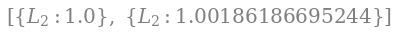

In [39]:
SEMRc = -79.59188167302904
Rc_sym = cancel(simplify(Rc_SEM_sympy_sim.subs({R3:1})))
sp.solve(Rc_sym-SEMRc, L2, dict=True)